# 실습 3: Principal Axes, Eigen Face, Denoising (2023.10.04)
### 빅데이터수치해석 입문 및 실습 
### 숙명여자대학교 기계시스템학부 심주용

- Reference: [Data-Driven Science and Engineering](https://www.databookuw.com/) by Steven L. Brunton, J. Nathan Kutz

##  Principal Axes: Noisy Cloud Data with an angle of 60$^{\circ}$

In this example, we aim to create random data with a variance of 4 (standard deviation, 2) along the 60-degree axis and a variance of 0.25 (standard deviation, 0.5) along the 150-degree axis. We then use principal component analysis to verify the principal axis transformation.

First, let's create 10,000 points for the x and y coordinates with a mean of 0 and a variance of 1 using the **np.random.randn function**.

To stretch this data by a factor of 2 along the x-axis and 0.5 along the y-axis, we multiply it by the following diagonal matrix:
$\begin{bmatrix}
2 & 0\\
0 & 0.5
\end{bmatrix}$.

Next, to rotate the data by an angle of 60 degrees, we multiply it by the rotation matrix $R_{\pi/3}, i.e., R_{60^{\circ}}$ =
$\begin{bmatrix}
cos(60^{\circ}) & -sin(60^{\circ})  \\
sin(60^{\circ})  & cos(60^{\circ}) 
\end{bmatrix}$
=
$\begin{bmatrix}
1/2 & -\sqrt3/2 \\
\sqrt3/2 & 1/2
\end{bmatrix}$.

Lastly, to move the center from (0,0) to (2,1), we add (2,1).


As a result, the following operation is applied to (x,y).
$\begin{bmatrix}
cos(60^{\circ}) & -sin(60^{\circ})  \\
sin(60^{\circ})  & cos(60^{\circ}) 
\end{bmatrix}$
$\begin{bmatrix}
2 & 0\\
0 & 0.5
\end{bmatrix}$
$\begin{bmatrix}
x\\
y
\end{bmatrix}$
+
$\begin{bmatrix}
2\\
1
\end{bmatrix}$

Lastly, we use it to plot confidence intervals using multiple standard deviations.


- Let's visualize the original scatter and sequential steps of transformations
- Let's explain the confidence interval of gaussian distribution (normal distribution)

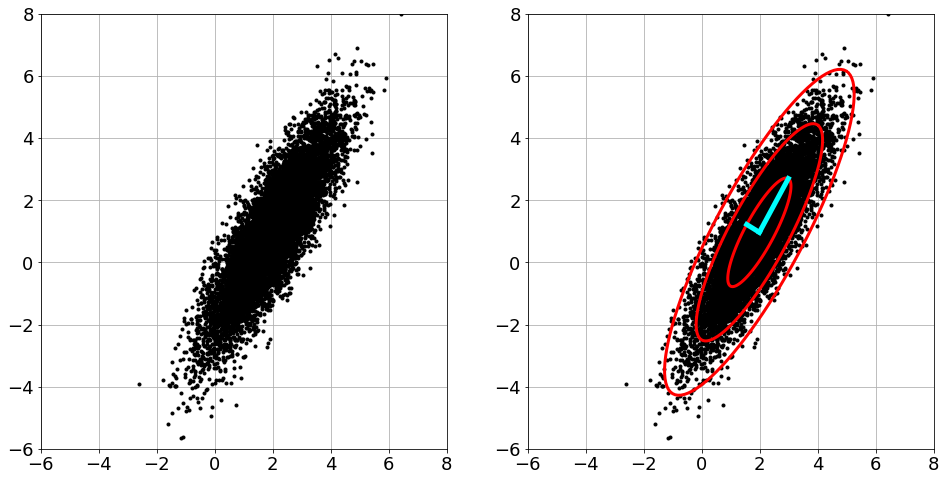

In [33]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [16, 8]

xC = np.array([2, 1])      # Center of data (mean)
sig = np.array([2, 0.5])   # Principal axes

theta = np.pi/3            # Rotate cloud by pi/3

R = np.array([[np.cos(theta), -np.sin(theta)],     # Rotation matrix
              [np.sin(theta), np.cos(theta)]])

nPoints = 10000            # Create 10,000 points
X = (R @ np.diag(sig) @ np.random.randn(nPoints,2).T).T + np.ones((nPoints,2)) @ np.diag(xC)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(X[:,0],X[:,1], 'k.')
ax1.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))

Xavg = np.mean(X,axis=0)                  # Compute mean
B = X - Xavg      # Mean-subtracted data

# Find principal components (SVD)
U, S, VT = np.linalg.svd(B/np.sqrt(nPoints-1),full_matrices=False)

ax2 = fig.add_subplot(122)
ax2.plot(X[:,0],X[:,1], 'k.')   # Plot data to overlay PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))

theta = 2 * np.pi * np.arange(0,1,0.01)
Rp = VT.T
# 1-std confidence interval
Xstd = Rp @ np.diag(S) @ np.array([np.cos(theta),np.sin(theta)])

ax2.plot(Xavg[0] + Xstd[0,:], Xavg[1] + Xstd[1,:],'-',color='r',lw=3)
ax2.plot(Xavg[0] + 2*Xstd[0,:], Xavg[1] + 2*Xstd[1,:],'-',color='r',lw=3)
ax2.plot(Xavg[0] + 3*Xstd[0,:], Xavg[1] + 3*Xstd[1,:],'-',color='r',lw=3)

# Plot principal components U[:,0]S[0] and U[:,1]S[1]
ax2.plot(np.array([Xavg[0], Xavg[0]+Rp[0,0]*S[0]]),
         np.array([Xavg[1], Xavg[1]+Rp[1,0]*S[0]]),'-',color='cyan',lw=5)
ax2.plot(np.array([Xavg[0], Xavg[0]+Rp[0,1]*S[1]]),
         np.array([Xavg[1], Xavg[1]+Rp[1,1]*S[1]]),'-',color='cyan',lw=5)

plt.show()

The first three standard deviation ellipsoids (red), and the two left singular vectors, scaled by singular values ($\sigma_1v_1 + x_C$ and $\sigma_2u_2 + x_C$: cyan).

## Eigen Face Continued

In this example, use the SVD of the eigenface example and reconstruct a dog face.

- Let's review the previous example
- We will understand the m*n image pixels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

mat_contents = scipy.io.loadmat('allFaces.mat')
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

# We use the first 36 people for training data
trainingFaces = faces[:,:np.sum(nfaces[:36])].T
avgFace = np.mean(trainingFaces, axis=0) # size n*m by 1

# Compute eigenfaces on mean-subtracted training data
X = trainingFaces - avgFace
U, S, VT = np.linalg.svd(X,full_matrices=False)

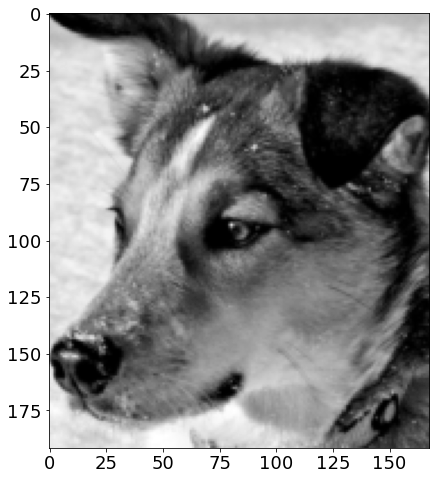

In [57]:
from matplotlib.image import imread
from skimage.transform import resize

img = imread(os.path.join('dog.jpg'))
img = img.mean(-1) # Convert RGB to grayscale
img = resize(img,(400,300))[30:30+n,20:20+m]
plt.imshow(img, cmap='gray')

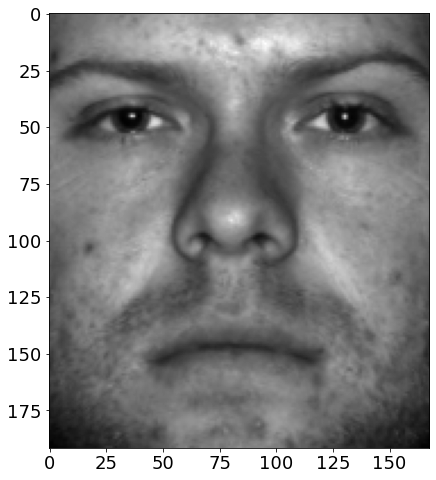

In [66]:
plt.imshow(faces[:,0].reshape((m,n)).T, cmap='gray')

In [64]:
testFace = img.T.reshape((m*n))
testFace.shape

(32256,)

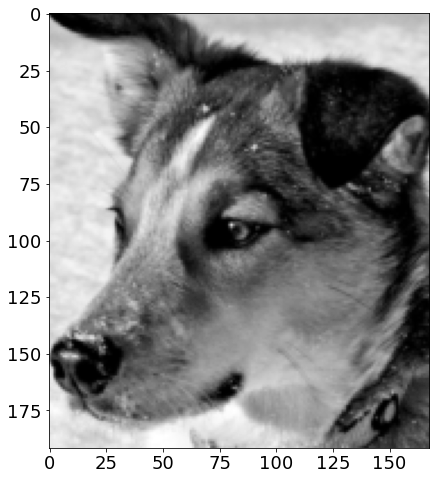

In [65]:
plt.imshow(testFace.reshape((m,n)).T, cmap='gray')

In [69]:
VT.shape

(2282, 32256)

In [72]:
U.shape, S.shape, VT.shape, X.shape

((2282, 2282), (2282,), (2282, 32256), (2282, 32256))

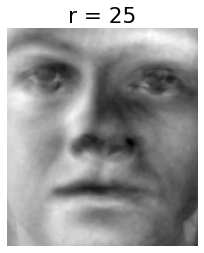

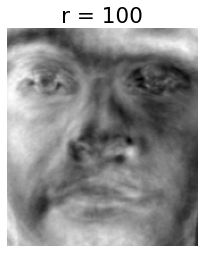

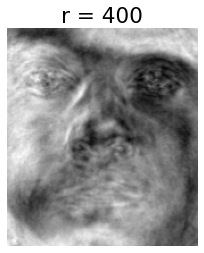

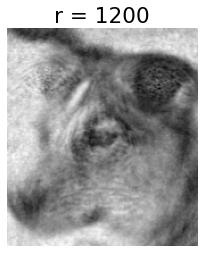

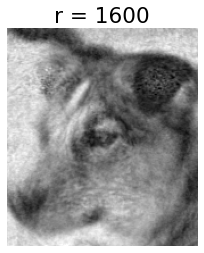

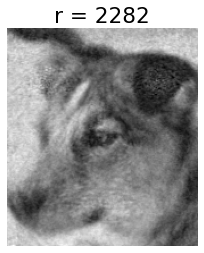

In [71]:
testFaceMS = testFace - avgFace
r_list = [25, 100, 400, 1200, 1600, 2282]

plt.rcParams['figure.figsize'] = [4, 4]

for r in r_list:
    Z_r = testFaceMS @ VT[:r,:].T # r principal components (# = r)
    reconFace = avgFace + Z_r @ VT[:r,:] # reconstruction using r eigen faces and r principal components
    img = plt.imshow(np.reshape(reconFace,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

## Rotation: Orthogonal Matrix of SVD

Geometric illustration of the SVD

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

theta = np.array([np.pi/15, -np.pi/9, -np.pi/20])
Sigma = np.diag([3, 1, 0.5]) # scale x, then y, then z

# Rotation about x axis
Rx = np.array([[1, 0, 0],
               [0, np.cos(theta[0]), -np.sin(theta[0])],
               [0, np.sin(theta[0]), np.cos(theta[0])]])

# Rotation about y axis
Ry = np.array([[np.cos(theta[1]), 0, np.sin(theta[1])],
               [0, 1, 0],
               [-np.sin(theta[1]), 0, np.cos(theta[1])]])

# Rotation about z axis
Rz = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
               [np.sin(theta[2]), np.cos(theta[2]), 0],
               [0, 0, 1]])

# Rotate and scale
X = Rz @ Ry @ Rx @ Sigma

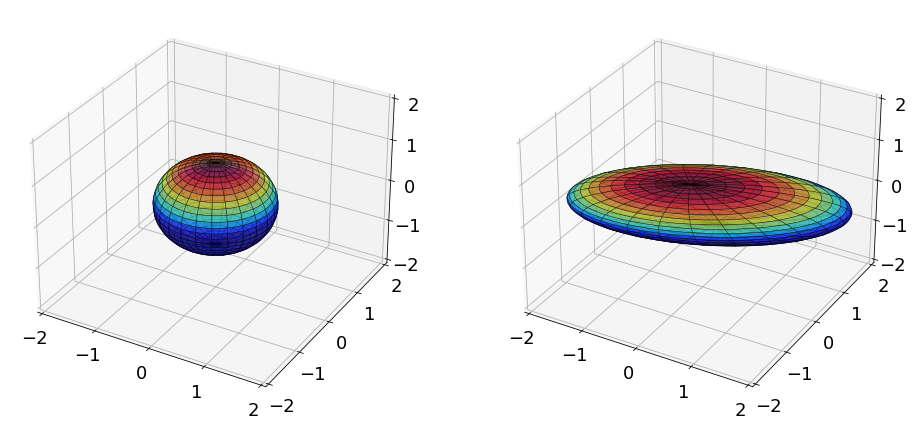

In [52]:
# Plot sphere
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
u = np.linspace(-np.pi, np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
surf1 = ax1.plot_surface(x, y, z, cmap='jet',alpha=0.6,facecolors=plt.cm.jet(z),linewidth=0.5,rcount=30,ccount=30)
surf1.set_edgecolor('k')
ax1.set_xlim3d(-2, 2)
ax1.set_ylim3d(-2, 2)
ax1.set_zlim3d(-2, 2)

xR = np.zeros_like(x)
yR = np.zeros_like(y)
zR = np.zeros_like(z)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        vec = [x[i,j], y[i,j], z[i,j]]
        vecR = X @ vec
        xR[i,j] = vecR[0]
        yR[i,j] = vecR[1]
        zR[i,j] = vecR[2]
        
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(xR, yR, zR, cmap='jet',alpha=0.6,linewidth=0.5,facecolors=plt.cm.jet(z),rcount=30,ccount=30)
surf2.set_edgecolor('k')
ax2.set_xlim3d(-2, 2)
ax2.set_ylim3d(-2, 2)
ax2.set_zlim3d(-2, 2)
plt.show()

## Truncation for Denoising
In this example, shown, we artificially construct a rank-2 matrix and we contaminate the signal with Gaussian white noise.
First, let's understand rank-1 and rank-2 matrices. From -3 to 3, define functions:
1. $cos(17t)e^{-t^2}$ and $sin(5t)e^{-t^2}$ 
2. $sin(11t)$ and $cos(13t)$


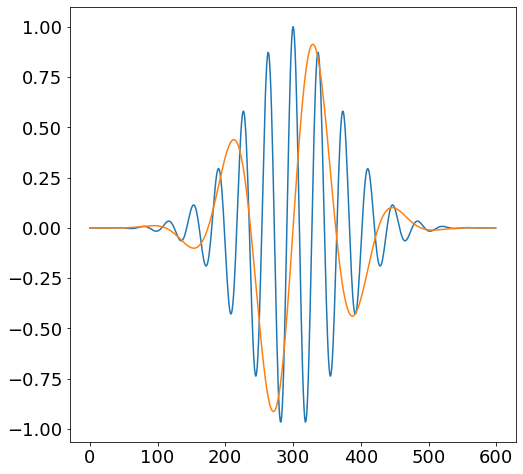

In [8]:
t = np.arange(-3,3,0.01)

Utrue = np.array([np.cos(17*t) * np.exp(-t**2), np.sin(11*t)]).T
Strue = np.array([[2, 0],[0, 0.5]])
Vtrue = np.array([np.sin(5*t) * np.exp(-t**2), np.cos(13*t)]).T

plt.plot(Utrue[:,:1] )
plt.plot(Vtrue[:,:1])

### Make a rank-1 matrix image

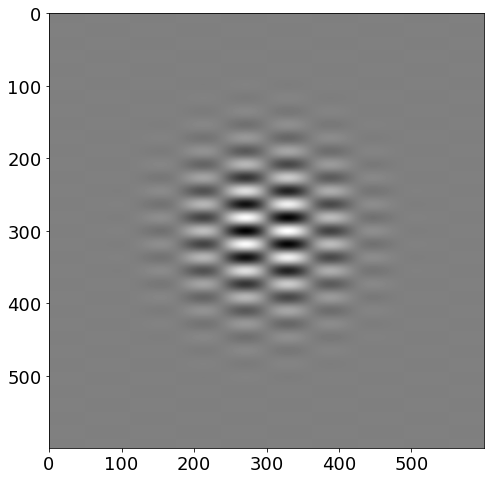

In [6]:
X = Utrue[:,:1] @ Strue[:1,:1] @ Vtrue.T[:1,:]
plt.imshow(X)

### Make a rank-2 matrix image

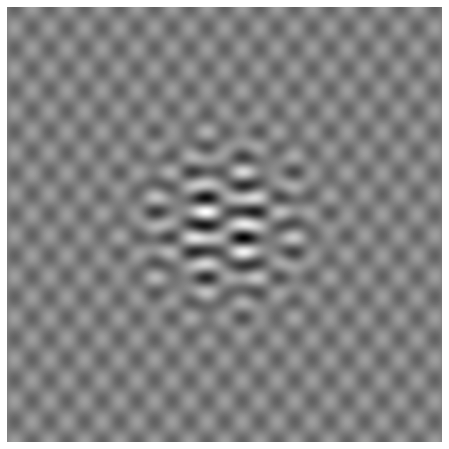

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

t = np.arange(-3,3,0.01)

Utrue = np.array([np.cos(17*t) * np.exp(-t**2), np.sin(11*t)]).T
Strue = np.array([[2, 0],[0, 0.5]])
Vtrue = np.array([np.sin(5*t) * np.exp(-t**2), np.cos(13*t)]).T

X = Utrue @ Strue @ Vtrue.T

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

### Add noise to the matrix

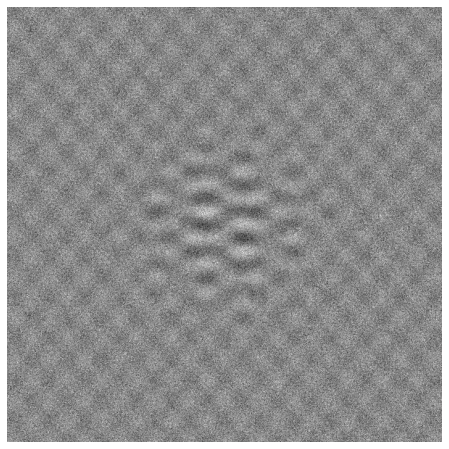

In [11]:
sigma = 1
Xnoisy = X + sigma*np.random.randn(*X.shape)
plt.imshow(Xnoisy)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

### Denoise using SVD

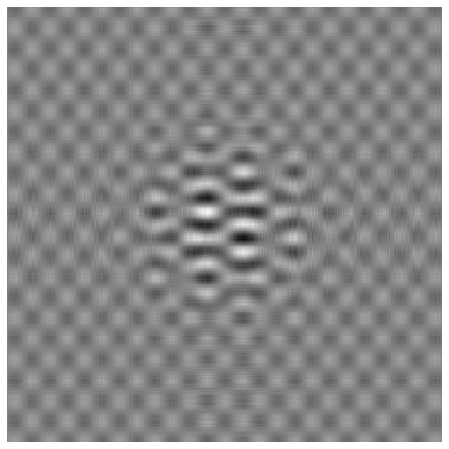

In [16]:
U, S, VT = np.linalg.svd(Xnoisy,full_matrices=0)
N = Xnoisy.shape[0]
r = 1

Xclean = U[:,:(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1),:]
plt.imshow(Xclean)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

### Use 90% cutoff

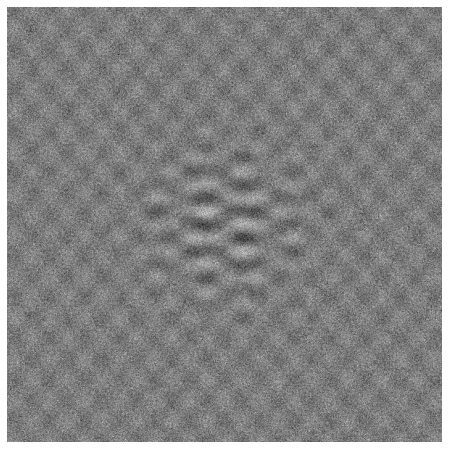

In [37]:
cdS = np.cumsum(S**2) / np.sum(S**2) # Cumulative energy
r90 = np.min(np.where(cdS > 0.90)) # Find r to capture 90% energy
X90 = U[:,:(r90+1)] @ np.diag(S[:(r90+1)]) @ VT[:(r90+1),:]
plt.imshow(X90)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

### Plot Singular Values

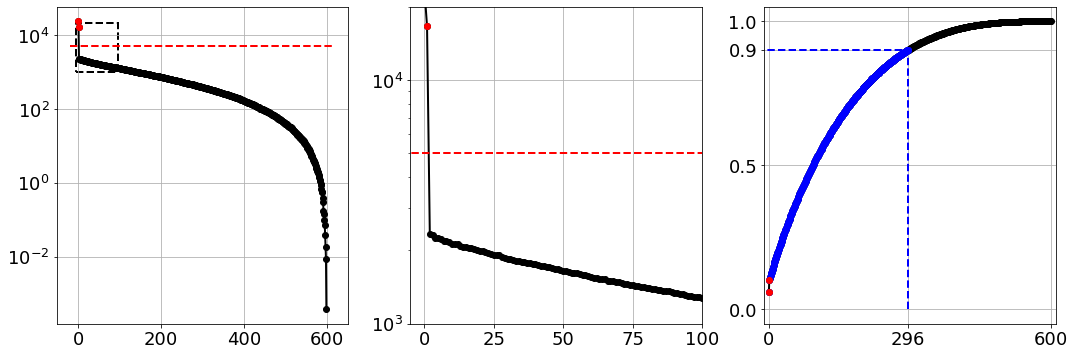

In [70]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)

cutoff = 5000 #56.56854249492381
ax1.semilogy(S**2,'-o', color='k', lw=2)
ax1.semilogy(np.diag(S[:(r+1)])**2,'o', color='r', lw=2)
ax1.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='r', lw=2)
rect = patches.Rectangle((-5,1000),100,20000,lw=2,linestyle='--',facecolor='none',edgecolor='k')
ax1.add_patch(rect)
# ax1.set_xlim((-10,610))
# ax1.set_ylim((0.003,300))
ax1.grid()

ax2 = fig.add_subplot(132)
ax2.semilogy(S**2,'-o', color='k', lw=2)
ax2.semilogy(np.diag(S[:(r+1)])**2,'o', color='r', lw=2)
ax2.plot(np.array([-20, N+20]),np.array([cutoff, cutoff]),'--', color='r', lw=2)
ax2.set_xlim((-5,100))
ax2.set_ylim((1000,20000))
# for tick in ax2.get_yticklabels():
#     tick.set_fontsize(5)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(cdS,'-o',color='k',lw=2)
ax3.plot(cdS[:(r90+1)],'o',color='b',lw=2)
ax3.plot(cdS[:(r+1)],'o',color='r',lw=2)
plt.xticks(np.array([0, r90, 600]))
plt.yticks(np.array([0, 0.5, 0.9, 1]))
plt.xlim((-10,610))
ax3.plot(np.array([r90, r90, -10]),np.array([0, 0.9, 0.9]),'--',color='b',lw=2)
ax3.grid()
fig.tight_layout(pad=0.5)
plt.show()

## PCA 시각화 (2020년도 기말고사 기출문제)

다음 “sensor_array_data.csv” 데이터는 6가지 다른 몸의 움직임에 대해서 각각 30번 측정한 센서 데이터이다. 이 데이터는 총 180측정한 데이터에 대해서 776개의 특징값을 가진다. 즉, 다음 “sensor_array_data.csv”는 아래와 같이 180 x 776 행렬이다.
 
 
<img src="https://github.com/jooyongsim/numerical2023/blob/main/photos/chair_sensor_data.png?raw=true " >
<!-- width = 400 height=200 -->

 
각각 다른 몸의 동작은 A, B, C, D, E, F로 구별되어 “sensor_array_data_grp.csv”에 저장이 되어있다. 
위 데이터에 주성분분석(Principal Component Analysis)를 적용하여 구한 주성분1과 주성분2를 이용한다고 하자. 이때 몸 동작 A, B, C, D, E, F 중 다른 동작과 가장 잘 구별되는 동작은 무엇인가? 

답: 동작 (_________________________)이다.


## Eigen Values, Eigen Vectors, Inverse Matrix

In [1]:
import numpy as np

np.array([1,2,3,4])

array([1, 2, 3, 4])

In [4]:
M = np.array([1,2,3,4]).reshape(2,2)
M

array([[1, 2],
       [3, 4]])

In [6]:
M_inv = np.linalg.inv(M)
M_inv

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [9]:
iden = np.matmul(M,M_inv)
iden


array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])

In [10]:
np.round(iden,5)

array([[1., 0.],
       [0., 1.]])

In [13]:
np.round(M@M_inv,5)

array([[1., 0.],
       [0., 1.]])

In [14]:
np.round(M_inv@M,5)

array([[1., 0.],
       [0., 1.]])

In [15]:
np.linalg.eig(M)

(array([-0.37228132,  5.37228132]),
 array([[-0.82456484, -0.41597356],
        [ 0.56576746, -0.90937671]]))

In [16]:
A = [7.3, 0.2, -3.7, -11.5, 1, 5.5, 17.7, 1.8, -9.3]
A = np.array(A).reshape((3,3))
A

array([[  7.3,   0.2,  -3.7],
       [-11.5,   1. ,   5.5],
       [ 17.7,   1.8,  -9.3]])

In [19]:
eig, X = np.linalg.eig(A)
np.round(eig,5), np.round(X,5)

(array([-4., -0.,  3.]),
 array([[-0.30151,  0.43644, -0.30151],
        [ 0.30151,  0.21822,  0.90453],
        [-0.90453,  0.87287, -0.30151]]))

In [26]:
#D = X_inv*A*X
X_inv = np.linalg.inv(X)
X_inv

array([[ 4.31161223,  0.66332496, -2.32163735],
       [ 3.66606056,  0.91651514, -0.91651514],
       [-2.32163735,  0.66332496,  0.99498744]])

In [28]:
np.round(X_inv@A@X,5)

array([[-4.,  0., -0.],
       [-0.,  0., -0.],
       [ 0.,  0.,  3.]])

## Importance of Data Alignment

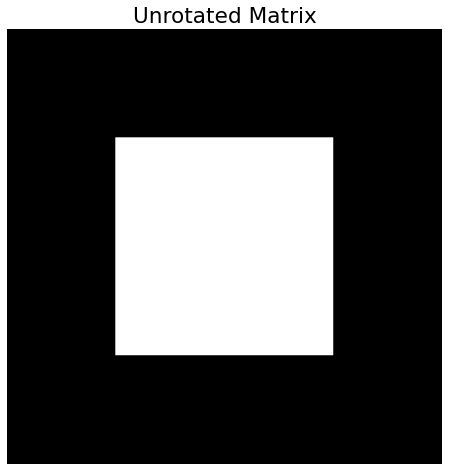

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 18})

n = 1000
q = int(n/4)
X = np.zeros((n,n))
X[(q-1):(3*q),(q-1):(3*q)] = 1

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')
plt.title('Unrotated Matrix')
plt.show()


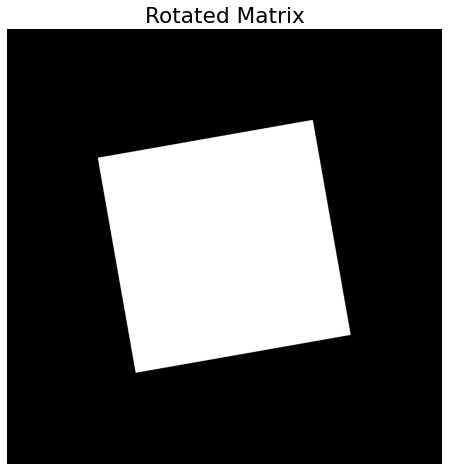

In [75]:
import skimage
X_rot = skimage.transform.rotate(X,10)
X_rot[np.nonzero(X_rot)] = 1

plt.imshow(X_rot)
plt.set_cmap('gray')
plt.axis('off')
plt.title('Rotated Matrix')
plt.show()

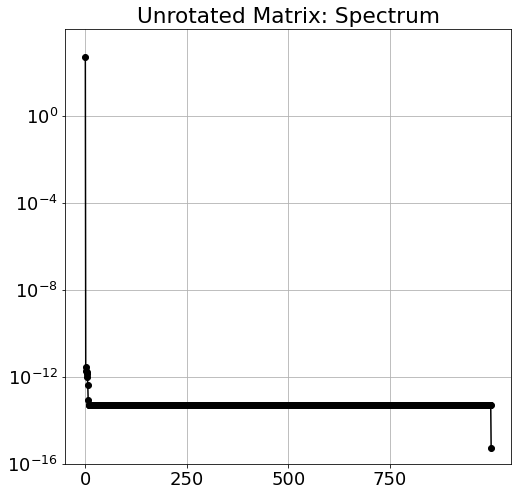

In [76]:
U, S, VT = np.linalg.svd(X,full_matrices=0)

plt.semilogy(S,'-o',color='k')
plt.ylim((10**(-16),10**(4)+1))
plt.yticks(np.power(10,np.arange(-16,4,4, dtype=float)))
plt.xticks(np.arange(0,1000,250))
plt.grid()
plt.title('Unrotated Matrix: Spectrum')
plt.show()

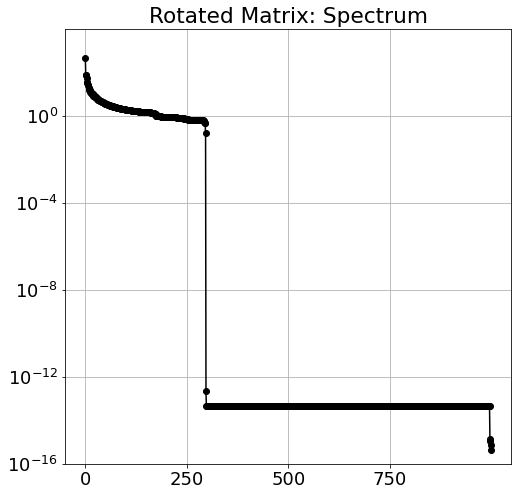

In [77]:
U_rot, S_rot, VT_rot = np.linalg.svd(X_rot,full_matrices=0)

plt.semilogy(S_rot,'-o',color='k')
plt.ylim((10**(-16),10**(4)+1))
plt.yticks(np.power(10,np.arange(-16,4,4, dtype=float)))
plt.xticks(np.arange(0,1000,250))
plt.grid()
plt.title('Rotated Matrix: Spectrum')
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2016\1882359708.py:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(alpha = 0.0)


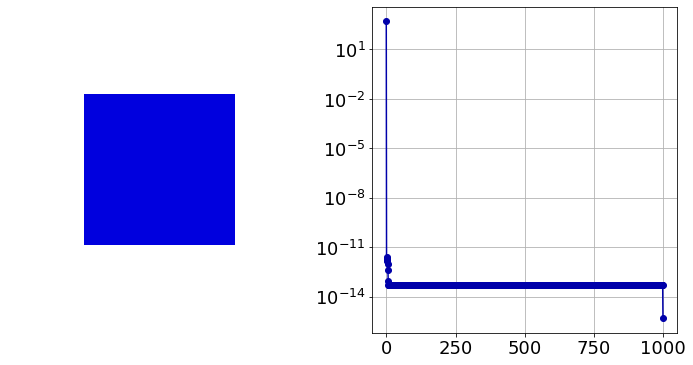

In [78]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import skimage.transform

plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 18})

n = 1000
q = int(n/4)
X = np.zeros((n,n))
X[(q-1):(3*q),(q-1):(3*q)] = 1

nAngles = 12 # Sweep through 12 different angles, from 0:4:44 degrees
cm_np = np.array([[0,0,2/3],
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])


cmap = plt.cm.jet
cmap.set_bad(alpha = 0.0)

U, S, VT = np.linalg.svd(X,full_matrices=0)

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
plt.imshow(np.ma.masked_where(X == 0, X),vmin=0,vmax=nAngles)
plt.set_cmap(cmap)
plt.axis('off')


ax2 = fig1.add_subplot(122)
plt.semilogy(S,'-o',color=tuple(cm_np[0]))
plt.grid()

plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2016\768308675.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[1].axis('on')


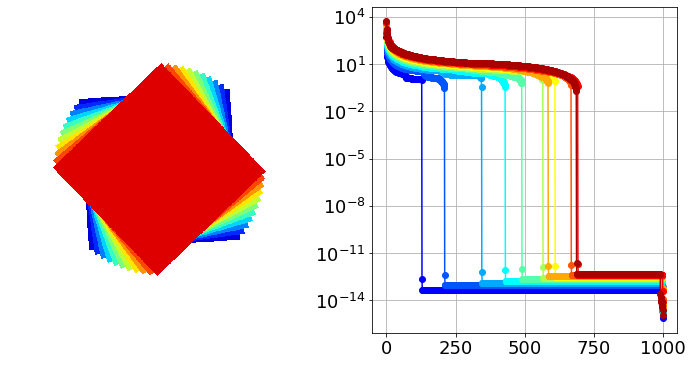

In [79]:
Xrot = X

fig, axs = plt.subplots(1,2)

for j in range(nAngles):
    Xrot = skimage.transform.rotate(X,j*4) #rotate by theta = j*4 degrees
    Xrot[np.nonzero(Xrot)] = j
    
    U, S, VT = np.linalg.svd(Xrot)

    axs[0].imshow(np.ma.masked_where(Xrot == 0, Xrot),vmin=0,vmax=nAngles)
    plt.set_cmap(cmap)
    axs[0].axis('off')

    axs[1].semilogy(S,'-o',color=tuple(cm_np[j]))
    axs[1].axis('on')
    axs[1].grid(1)

plt.show()